In [232]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [407]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")

In [234]:
################
# Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [235]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
#        plot_ts_and_points(y, start_point, step, ts_ax)
        ts_ax.set_title('Original')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

#### Загрузим исходный нестационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


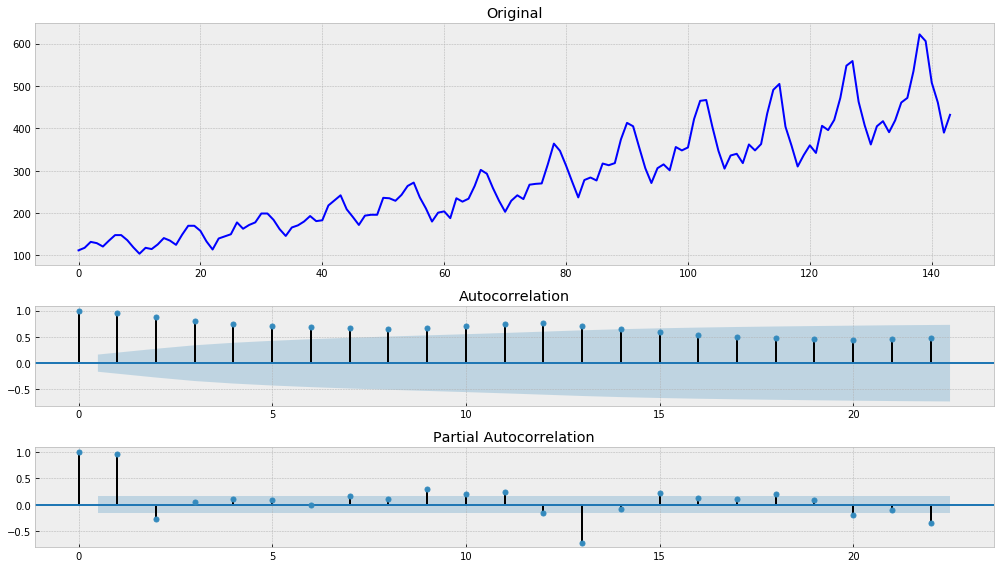

In [325]:
series_1 = airlines_passengers["Count"]

tsplot(series_1)

#### Приведем ряд к стационарному

Results of Dickey-Fuller Test:
Test Statistic                -6.254273e+00
p-value                        4.377572e-08
#Lags Used                     2.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


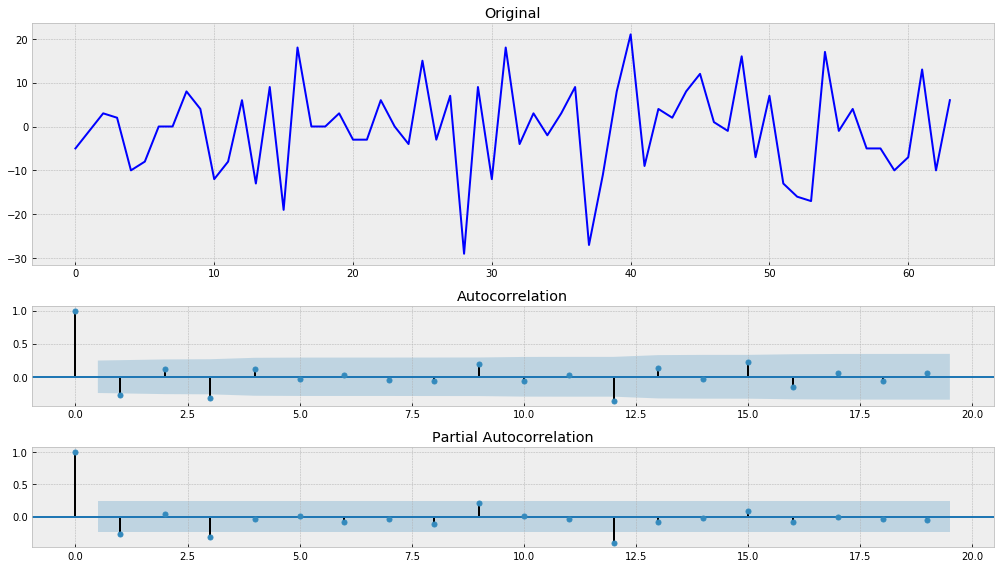

In [326]:
series_1_0 = boxcox(series_1, 0)
series_1_0 = np.diff(series_1, 1)

series_1_stat = []
for i in range(len(series_1_0)):
    if i+12 == 76:
        break      
    c = series_1_0[i] - series_1_0[i+12]
    series_1_stat.append(c)


tsplot(series_1_stat)

In [327]:
def initial_trend(series, season_len):
    i = 0
    return sum([float(series[i + season_len] - series[i]) / season_len])

In [328]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [329]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [337]:
def plot_tema(alpha, beta, gamma, ser=series_1, ser_to_plot=airlines_passengers["Count"], n_preds=12):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

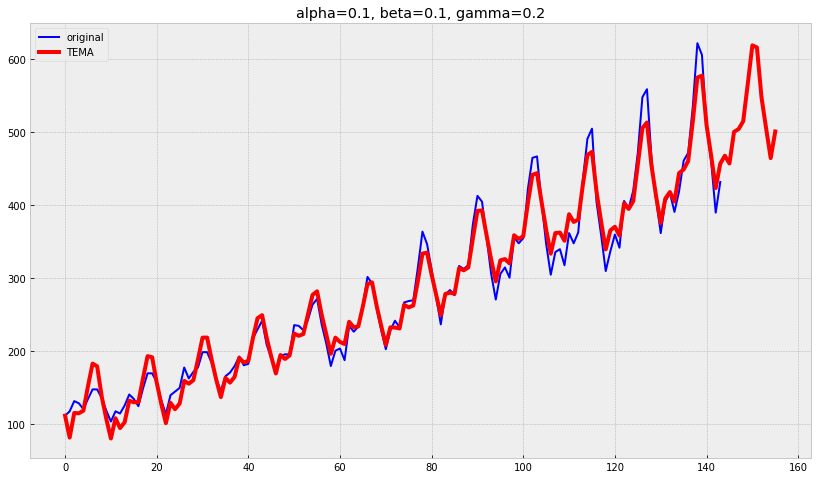

In [338]:
plot_tema(0.1, 0.1, 0.2)

#### Приближение для нестационарного графика

In [339]:
train, test, val = series_1[:70], series_1[70:75], series_1[75:]

In [340]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
#    print(error)
    return error

In [341]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
#opt = minimize(mse, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

In [342]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 41.32055706483718
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.56319402e-05,  5.60072067e+02, -1.60816420e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 24
   status: 0
  success: True
        x: array([0.69020419, 0.        , 1.        ])


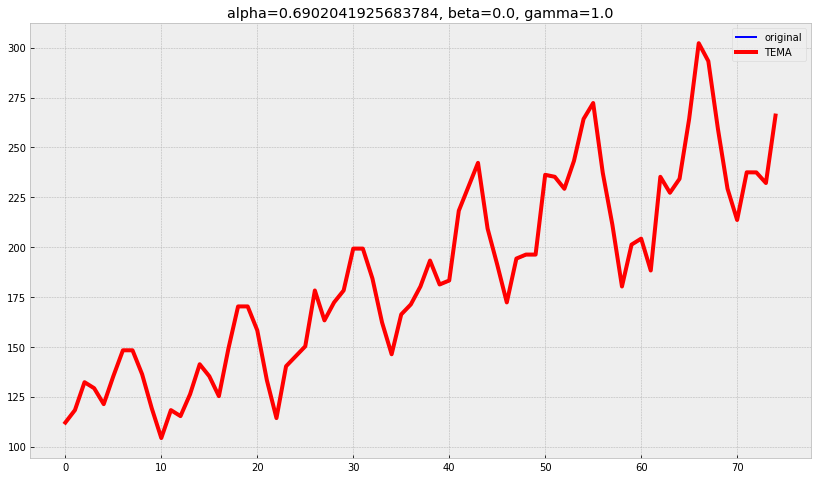

In [343]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_2[:70], n_preds=len(test))

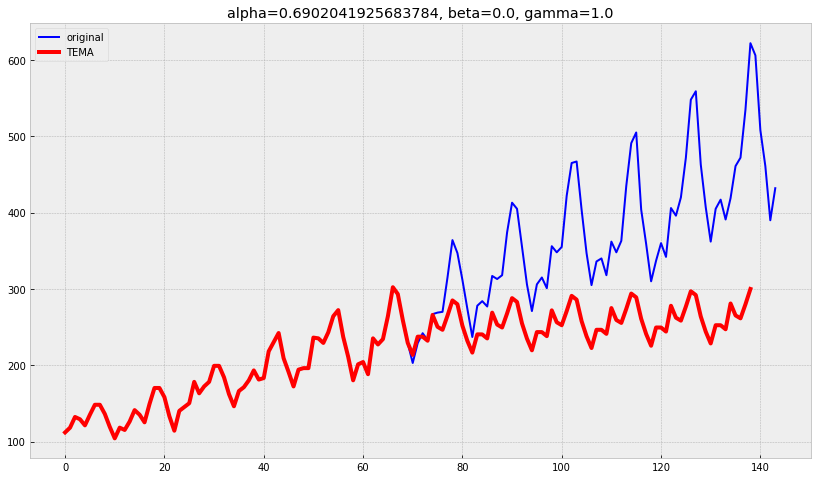

In [344]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series_2[:70], ser_to_plot=series_2, n_preds=len(val))

In [345]:
# ошибка при разных периодах предсказания
from sklearn.metrics import mean_squared_error

for i in range(13):
    
    n_preds = i
    tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, n_preds)
    error = mean_squared_error(tema, series_2[:70+n_preds], squared=False)
    print('n_preds =', i, 'mse =', error)

n_preds = 0 mse = 0.2482078621984865
n_preds = 1 mse = 1.2798391019901014
n_preds = 2 mse = 1.617744102622386
n_preds = 3 mse = 1.6923462716883637
n_preds = 4 mse = 1.6839034299128468
n_preds = 5 mse = 1.676962672310412
n_preds = 6 mse = 2.7144776685234326
n_preds = 7 mse = 3.803016271191579
n_preds = 8 mse = 6.813239285585416
n_preds = 9 mse = 11.176314648304208
n_preds = 10 mse = 13.398060479807135
n_preds = 11 mse = 14.894801994192902
n_preds = 12 mse = 15.513277256777474


#### Приближение для стационарного графика

In [397]:
series_1_stat = pd.Series(series_1_stat)
train_s, test_s, val_s = series_1_stat[:50], series_1_stat[50:60], series_1_stat[60:]

In [398]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

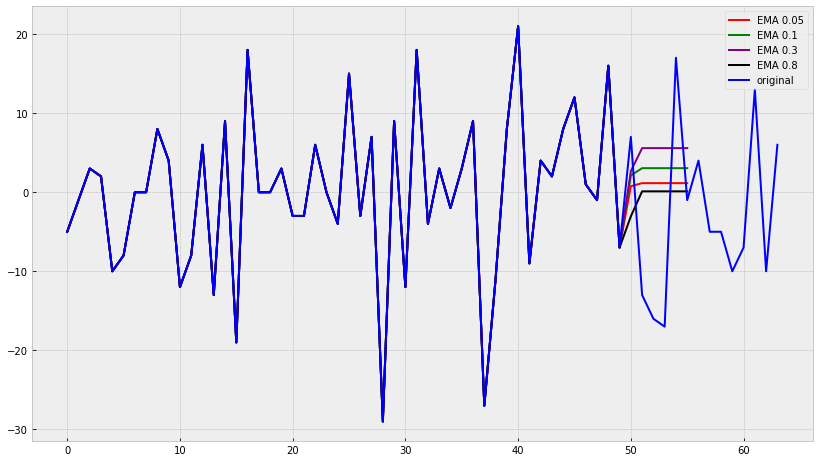

In [399]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(train_s, alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(series_1_stat, color='blue',label='original')
    plt.legend()

In [400]:
def mse_s(X):
    alpha = X
    result, _ = exponential_moving_average(train_s, alpha, 5)
    predictions = result[-len(test):]
    error_s = mean_squared_error(predictions, test)
#    print(error)
    return error_s

In [401]:
opt_s = minimize(mse_s, x0=[0], method="L-BFGS-B")

In [402]:
alpha_opt = opt_s.x
print(opt)

      fun: 41.32055706483718
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.56319402e-05,  5.60072067e+02, -1.60816420e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 24
   status: 0
  success: True
        x: array([0.69020419, 0.        , 1.        ])


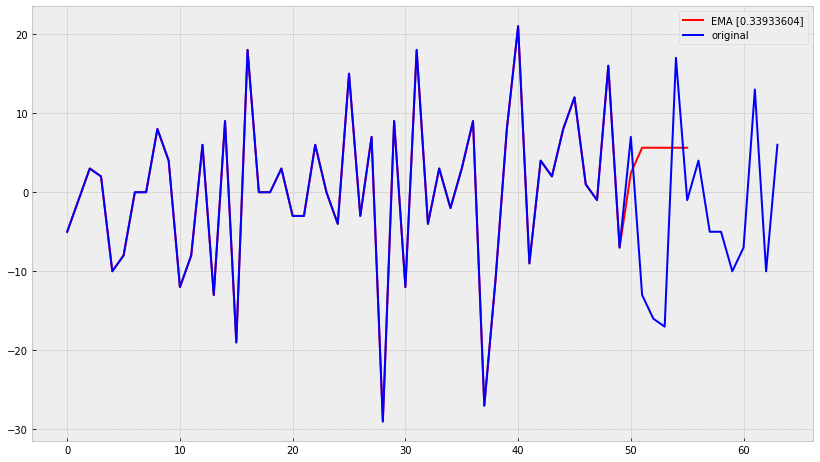

In [403]:
alpha = alpha_opt

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = exponential_moving_average(train_s, alpha, 5)
    plt.plot(ser, color='red', linewidth='2', label='EMA {}'.format(alpha))
    plt.plot(series_1_stat, color='blue',label='original')
    plt.legend()

In [406]:
# ошибка при разных периодах предсказания
from sklearn.metrics import mean_squared_error

for i in range(1, 10):
    
    n_preds = i
    ema, _ = exponential_moving_average(train_s, alpha, n_preds)
    error = mean_squared_error(ema, series_1_stat[:len(train_s)+1+n_preds], squared=False)
    print('n_preds =', i, 'mse =', error)

n_preds = 1 mse = 2.659776626115236
n_preds = 2 mse = 3.9706364913381447
n_preds = 3 mse = 4.995508512886156
n_preds = 4 mse = 5.181999130212555
n_preds = 5 mse = 5.211316937827173
n_preds = 6 mse = 5.169894655828033
n_preds = 7 mse = 5.311694752580318
n_preds = 8 mse = 5.445182165149204
n_preds = 9 mse = 5.76418966503178
